# 🧠 LunarLander-v3 RL Prototype

Dieser Prototyp dient als Grundlage für deine Masterarbeit *„Automatische Architektur- und Hyperparameteroptimierung für Reinforcement-Learning-Agenten mittels evolutionärer Algorithmen“*.

Er implementiert einen einfachen Policy-Gradient-Agenten (REINFORCE) für die **LunarLander-v3**-Umgebung aus `gymnasium` und ist so strukturiert, dass evolutionäre Komponenten später leicht integriert werden können.

## Abschnitt 1: Setup & Imports

Wir importieren alle notwendigen Bibliotheken und initialisieren die Umgebung.

In [ ]:
pip install torch gymnasium swig gymnasium[box2d]

In [11]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Sicherstellen, dass wir eine GPU nutzen können, falls vorhanden
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Verwendetes Gerät: {device}")

Verwendetes Gerät: cpu


## Abschnitt 2: Environment Description

Wir erstellen die LunarLander-Umgebung und inspizieren Beobachtungs- und Aktionsraum.

In [12]:
env = gym.make('LunarLander-v3')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"Zustandsdimension: {state_dim}")
print(f"Anzahl möglicher Aktionen: {action_dim}")

Zustandsdimension: 8
Anzahl möglicher Aktionen: 4


## Abschnitt 3: Policy Network

Ein einfaches neuronales Netzwerk mit:
- Zwei vollvernetzten Schichten
- ReLU-Aktivierung
- Softmax-Ausgabe für Wahrscheinlichkeiten

Die Hyperparameter `hidden_size` und `learning_rate` sind klar definiert und können später durch evolutionäre Optimierung angepasst werden.

In [13]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Hyperparameter (später: Genome-Parameter für evolutionäre Suche)
hidden_size = 128
learning_rate = 1e-3

policy_net = PolicyNetwork(state_dim, action_dim, hidden_size).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

## Abschnitt 4: Training Loop (REINFORCE)

Wir implementieren eine einfache Policy-Gradient-Methode (REINFORCE), um den Agenten zu trainieren.

Später kann hier die **Fitness-Evaluation** durch einen evolutionären Algorithmus ersetzt oder ergänzt werden.

In [15]:
env = gym.make("LunarLander-v3")
print(env.spec.max_episode_steps)


1000


In [17]:
def select_action(state):
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    probs = policy_net(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

def compute_returns(rewards, gamma=0.99):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    return returns

# Trainingsparameter
num_episodes = 500
gamma = 0.99
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    log_probs = []
    rewards = []

    done = False
    while not done:
        action, log_prob = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state

    returns = compute_returns(rewards, gamma)
    loss = -torch.sum(torch.stack(log_probs) * returns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_reward = sum(rewards)
    reward_history.append(total_reward)

    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(reward_history[-10:])
        print(f"Episode {episode+1}/{num_episodes} | Durchschnittlicher Reward: {avg_reward:.2f}")

Episode 10/500 | Durchschnittlicher Reward: -151.44
Episode 20/500 | Durchschnittlicher Reward: -192.06
Episode 30/500 | Durchschnittlicher Reward: -171.36
Episode 40/500 | Durchschnittlicher Reward: -217.00
Episode 50/500 | Durchschnittlicher Reward: -236.97
Episode 60/500 | Durchschnittlicher Reward: -263.98
Episode 70/500 | Durchschnittlicher Reward: -268.14
Episode 80/500 | Durchschnittlicher Reward: -325.96
Episode 90/500 | Durchschnittlicher Reward: -301.60
Episode 100/500 | Durchschnittlicher Reward: -272.01
Episode 110/500 | Durchschnittlicher Reward: -298.28
Episode 120/500 | Durchschnittlicher Reward: -172.57
Episode 130/500 | Durchschnittlicher Reward: -283.35
Episode 140/500 | Durchschnittlicher Reward: -196.31
Episode 150/500 | Durchschnittlicher Reward: -188.72
Episode 160/500 | Durchschnittlicher Reward: -244.65
Episode 170/500 | Durchschnittlicher Reward: -163.96
Episode 180/500 | Durchschnittlicher Reward: -146.44
Episode 190/500 | Durchschnittlicher Reward: -208.81
Ep

## Abschnitt 5: Evaluation & Visualisierung

Wir visualisieren den Trainingsverlauf und führen eine Testepisode durch.

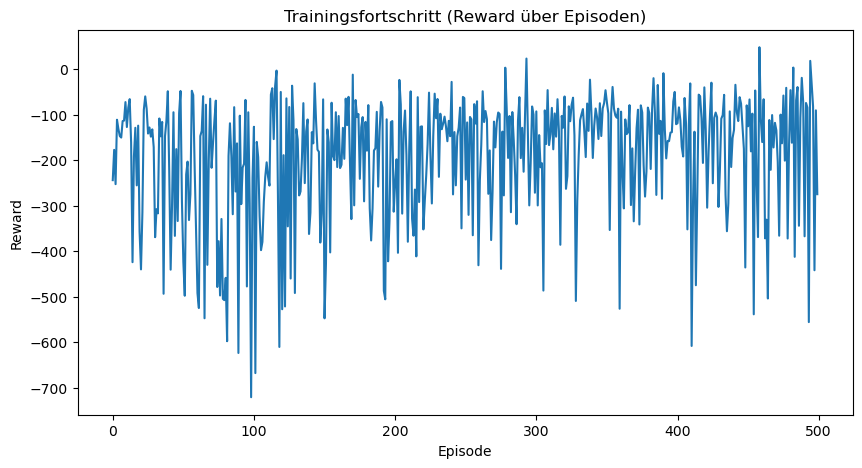

Gesamt-Reward in Testepisode: -71.36


In [18]:
# Plot der Rewards
plt.figure(figsize=(10,5))
plt.plot(reward_history)
plt.title('Trainingsfortschritt (Reward über Episoden)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Testepisode mit Render
state, _ = env.reset()
done = False
total_reward = 0
while not done:
    action, _ = select_action(state)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

print(f"Gesamt-Reward in Testepisode: {total_reward:.2f}")
env.close()

## Abschnitt 6: Platzhalter – Evolutionäre Optimierung

Hier wird später die **evolutionäre Architektur- und Hyperparameteroptimierung** integriert.

### Idee:
- **Genom:** codiert `hidden_size`, `learning_rate`, Anzahl Schichten etc.
- **Fitness:** durchschnittlicher Reward über mehrere Episoden.
- **Mutation & Selektion:** Anpassung der Hyperparameter und Netzwerkarchitekturen.
- **Surrogat-Modell:** Schätzt Fitnesswerte zur Beschleunigung.

Platzhalter-Funktion:
```python
def evaluate_genome(genome):
    # TODO: Ersetze REINFORCE-Training durch EA-basierte Fitnessbewertung
    pass
```

In [28]:
import time

env = gym.make("LunarLander-v3", render_mode="human")
state, _ = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = select_action(state)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward
    time.sleep(0.02)  # Verlangsamt Simulation leicht, damit du es besser sehen kannst

print(f"Gesamt-Reward dieser Episode: {total_reward:.2f}")
env.close()


Gesamt-Reward dieser Episode: -112.68
